<a href="https://colab.research.google.com/github/AntonAIG/applied_ml_learning/blob/main/ashrae_load_archetypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Archetypes for Customers Segmentation
AMI based measurement data for energy consumption in residential and commercial buildings can be used to perform consumer analysis and segmentation. This can be evaluated using unsupervised machine learning.


---
**Table of Contents**


*   Introduction
*   Business Question
*   Data Sources and Description
*   Exploratory Data Analysis
*   Preprocessing
*   Modeling
*   Conclusion and Recommendation

### Introduction

Classifying various load/energy profiles of consumers connected to a grid requires the use of unsupervised machine learning clustering techniques. In a given number of residential buildings, there is a fixed number of characteristic profiles that can be used to represent all the posible trends in consumption. This will help the utilities to understand various consumer behaviors and target specific incentives such as demand response or periodical tariff reduction.

This project is based on the ASHRAE Great Energy Predictor III project available in [Kaggle](https://www.kaggle.com/c/ashrae-energy-prediction/overview). Using the AMI measurements of just electricity, we can begin to perform a series of analysis to determine the consumer behavior and unique parterns.

### Business Question

A utility company that collects measurement data from its customers would like to know specific consumption behaviors and parterns that characterise all the customers. Some customers might have double peaks, some might have single peaks, while others have steadily rising profiles from morning till midnight. This knowledge can be used to further plan and recommend energy savings measures, peak reduction or cost reduction incentives.

### Data Sources and Description

The dataset for this evaluation was obtained from the ASHRAE Great Energy Predictor III project. The data consists of: building_metadata.csv, sample_submission.csv, test.csv, train.csv, weather_test.csv, and weather_train.csv datasets.

The data containes information about 1402 buildings and there respective sites, meter readings, and weather data. Since we are not performing regressive prediction but unsupervised clustering, we only need the time series data of meter readings (electricity).

In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline
sns.set_theme(style='whitegrid', palette='Accent')

In [ ]:
meters = pd.read_csv("/content/train.csv", parse_dates=["timestamp"])
meters.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [ ]:
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10529244 entries, 0 to 10529243
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int64         
 1   meter          int64         
 2   timestamp      datetime64[ns]
 3   meter_reading  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 321.3 MB


In [ ]:
meters["building_id"].nunique()

1442

The data shows that there are more than 7 million entries of time series data for more than 1000 buildings. The timestamp is in datetime format. This information will be useful in producing daily profiles of each building.

In [ ]:
meters.describe()

,building_id,meter,meter_reading
count,1.052924e+07,1.052924e+07,1.052924e+07
mean,7.942117e+02,6.584333e-01,3.531609e+03
std,4.241736e+02,9.313986e-01,2.095024e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.890000e+02,0.000000e+00,1.565000e+01
50%,8.910000e+02,0.000000e+00,7.276360e+01
75%,1.169000e+03,1.000000e+00,2.498500e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [ ]:
meters.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    1
dtype: int64

There are some null values in the dataset, and we have to remove them before further evaluation.

---

Next we can sort the data by the timestamp, and convert the meter type categorical data to int

In [ ]:
meters.dropna(axis=0, inplace=True)

In [ ]:
meters.sort_values(by="timestamp", inplace=True, axis=0)
meters.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.000
1543,1104,1,2016-01-01,0.000
1542,1104,0,2016-01-01,142.341
1541,1103,0,2016-01-01,43.321
1540,1102,2,2016-01-01,3234.380


In [ ]:
meters['meter'] = meters['meter'].astype(int)

In [ ]:
print("Number of meters: {}, \nUnique meters: {}".format(meters['meter'].nunique(), meters['meter'].unique()))

Number of meters: 4, 
Unique meters: [0 1 2 3]


There are 4 smart meter devices that take measurements for Electricity, Chilled Water, Steam, and Hot Water respectively.

Let's select meters with only Electricity (type 0)

In [ ]:
meter = meters[meters['meter']==0]
meter.drop(["meter"], axis=1, inplace=True)
meter.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,building_id,meter_reading
count,6.314708e+06,6.314708e+06
mean,7.015306e+02,1.587181e+02
std,4.119571e+02,3.626657e+02
min,0.000000e+00,0.000000e+00
25%,3.420000e+02,1.649500e+01
50%,6.960000e+02,5.693750e+01
75%,1.054000e+03,1.562500e+02
max,1.448000e+03,4.433650e+04


In [ ]:
meter['building_id'].nunique()

1406

The average value of electricity consumption is 142 kWh for the entire meter readings from all the buildings.

### Exploratory Data Analysis

Focusing on the electricity measurements, we can take a look at the trends and properties in the time series data.

---
Before this, we have to modify the data such that each building_id will have a set of 24 hours average measurement representing one day.

In [ ]:
meter['hour'] = np.int8(meter['timestamp'].dt.hour)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
meter.drop([0], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
def building_profiles(dataframe, guide='', grouper=''): #guide=building_id, grouper=hour

  profiles = pd.DataFrame([], columns=dataframe.columns)

  unique_items = dataframe[guide].unique().astype(int)
  
  col1 = []
  col2 = []
  col3 = []
  for item in unique_items:
    profile = dataframe[dataframe[guide]==item]
    profile.groupby(by=grouper, as_index=False).mean()
    profile[guide] = profile[guide].astype(int)
    profile.drop(['timestamp'], axis=1, inplace=True)
    day_profile = profile.iloc[24:48]
    column1 = list(day_profile['building_id'])
    column2 = list(day_profile['meter_reading'])
    column3 = list(day_profile['hour'])

    col1.extend(column1)
    col2.extend(column2)
    col3.extend(column3)
  
  profiles['building_id'] = col1
  profiles['meter_reading'] = col2
  profiles['hour'] = col3

  return profiles

In [ ]:
data = building_profiles(meter, guide='building_id', grouper='hour')
data.drop(['timestamp'], axis=1, inplace=True)
data.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

(33720, 3)

Let's take a look at all the building profiles together in a line plot.

Text(0, 0.5, 'Electricity Consumption (kWh)')

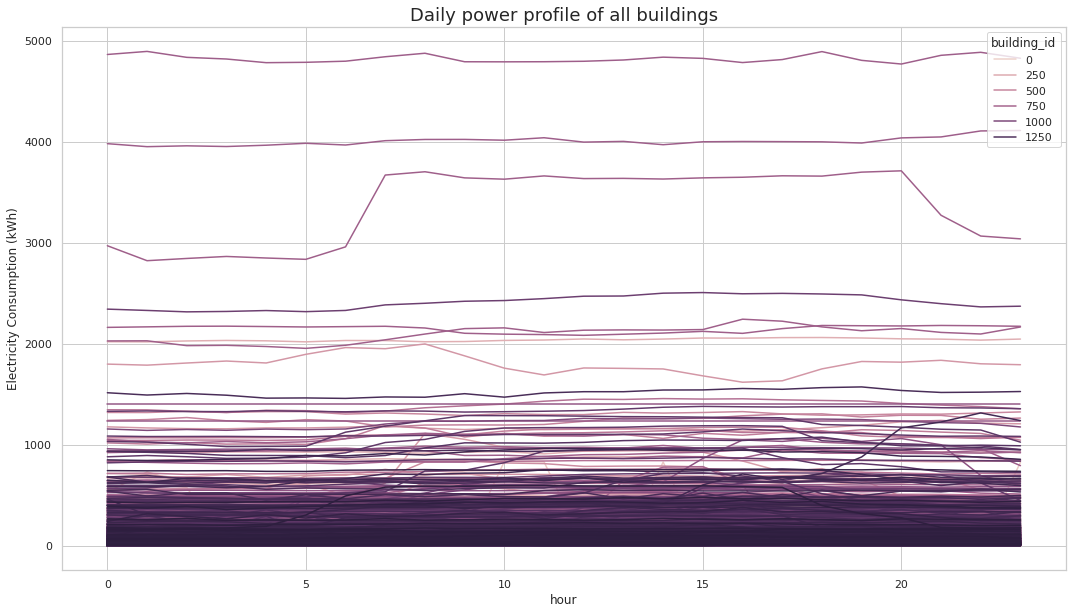

In [ ]:
fig, ax = plt.subplots(figsize=(18,10))

sns.lineplot(x='hour', y='meter_reading', data=data, hue='building_id')
ax.set_title('Daily power profile of all buildings', fontsize=18)
ax.set_ylabel('Electricity Consumption (kWh)')

From the figure above, we can see the differences in load profiles for all the buildings. This is what we want to classifiy.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


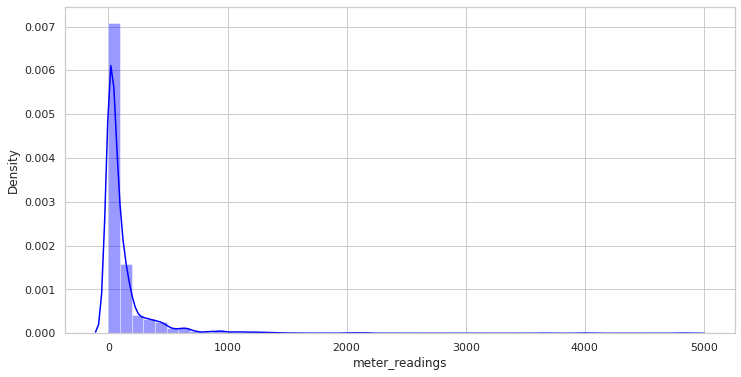

In [ ]:
# distribution plot

fig, ax = plt.subplots(figsize=(12,6))

sns.distplot(data['meter_reading'], color='blue', axlabel='meter_readings')

The distribution plot shows that most of the meter readings are less than 1000 kWh


---

We have to reshape the selected meter readings to an n x 24 series in preperation for modeling. This is because we want to consider representative daily profiles for each building.

In [ ]:
#reshape the meter_readings to n x 24 series

readings = data['meter_reading'].values.reshape(1405,24)

### Preprocessing

From the line plot of all building daily measuremets, we can see that the scale of the profiles vary considerably. This means that some buildings consume more power because they are larger than others. Larger building require more electricity. However, the purpose of this evalution is to define Load Architypes based on daily trends in the consumption. This means that we have to normalize the series `readings` into 0 - 1 interval for easier clustering. Norlamization will improve the accuracy of our clustering algorithm.

In [ ]:
def scaler_function(series):
  scaler = MinMaxScaler()

  for i in range(len(series)):
    row = series[i]
    r = scaler.fit_transform(row.reshape(-1,1))
    series[i] = r.reshape(1,-1)
    i+=1
  return series


In [ ]:
readings = scaler_function(readings)

**Principal Component Analysis**

The PCA can be performed for a time series data to reduce dimensionality thereby reducing the distance between data points. 

In [ ]:
pca = PCA(n_components=2)
readings_transformed = pca.fit_transform(readings)

print(readings_transformed[0:10])

[[-0.96040396  1.31318156]
 [ 0.22457592 -0.06652641]
 [-0.36714411  1.32907242]
 [ 1.68276584 -0.94914249]
 [ 0.67605642 -0.13817751]
 [-0.69006866  1.29076967]
 [ 0.77315763 -0.55564155]
 [-0.0501992   0.96519344]
 [ 1.25144447 -0.34955685]
 [ 0.05093865 -0.86650631]]


### Modeling

The clustering can now be performed using basic KMeans clustering from sklearn.

In [ ]:
#cluster_count = math.ceil(math.sqrt(len(readings)))
cluster_count = 10

km = KMeans(n_clusters=cluster_count, max_iter=10000)  
labels = km.fit_predict(readings_transformed)

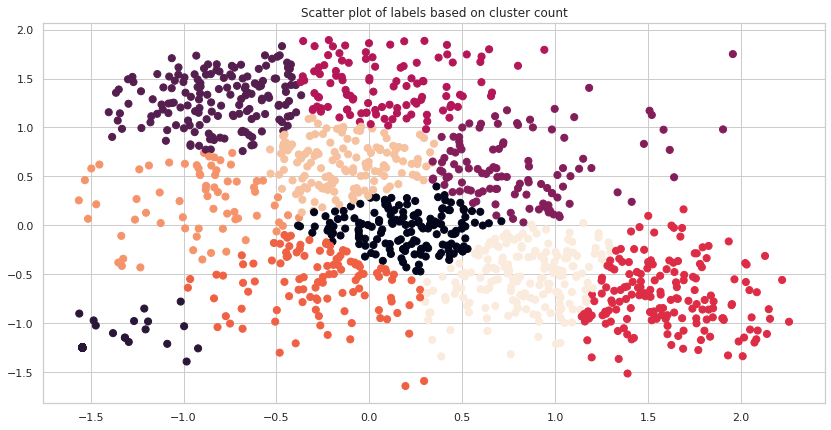

In [ ]:
plt.figure(figsize=(14,7))
plt.scatter(readings_transformed[:,0], readings_transformed[:,1], c=labels, s=50)
plt.title('Scatter plot of labels based on cluster count')
plt.show()

From the scatter plot above, we can clearly see 10 distinct classifications of the clusters representing 10 classifications of the load profiles. You can iteratively adjust the number of clusters till the label profile fits perfectly into the respective clusters. For this evaluation, the ideal number of clusters is 10

In [ ]:
print('max {}, min {}'.format(max(labels), min(labels)))

max 9, min 0


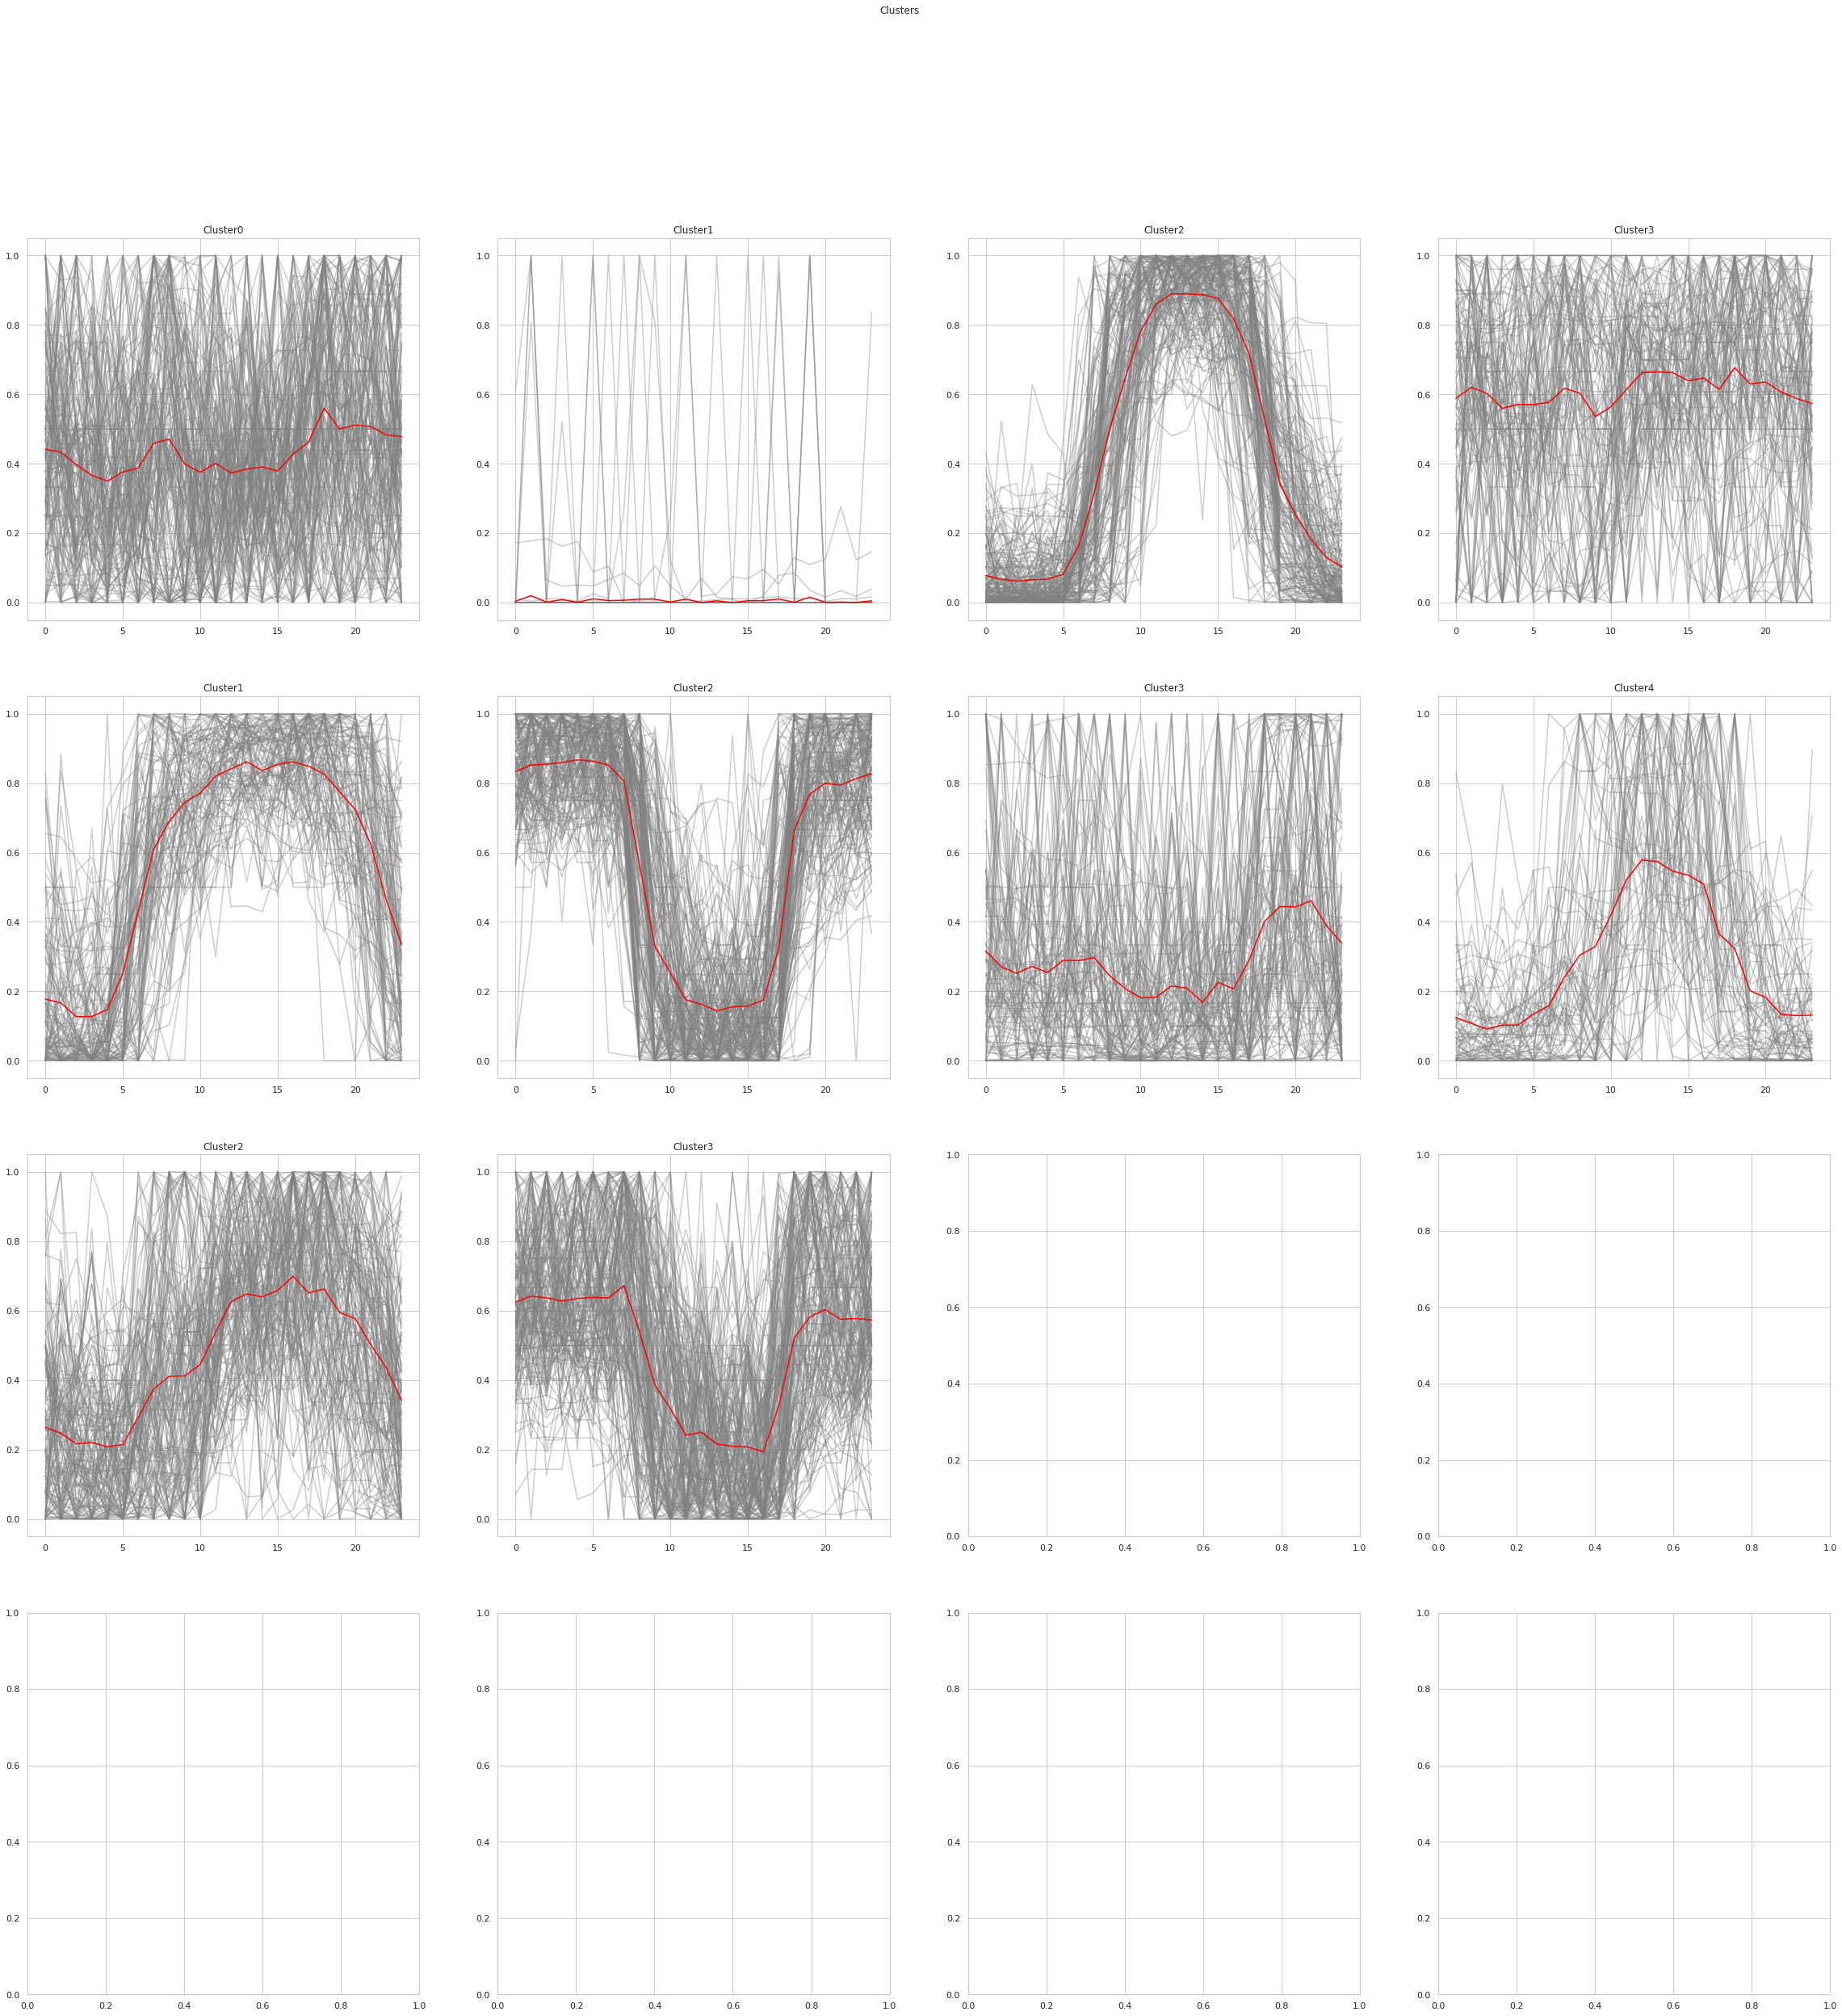

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(40,40))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels): #label=8
  cluster = []
  for i in range(len(labels)): #i=1402
    if (labels[i]==label):
      axs[row_i, column_j].plot(readings[i], c='gray', alpha=0.4)
      cluster.append(readings[i])
  if len(cluster) > 0:
    axs[row_i, column_j].plot(np.average(np.vstack(cluster), axis=0), c='red')
  axs[row_i, column_j].set_title("Cluster"+str(row_i+column_j))
  column_j+=1
  if column_j%plot_count == 0:
    row_i+=1
    column_j=0
plt.show()

The image above shows the various load Architypes that represents similar load profile parterns grouped together. Not all of them makes sense, but we can clearly see **9** out of **10** consumption classifications.


---

There are:
* Double peak consumption profile (cluster 0)
* Constant consumption profiles (cluster 3)
* Narrow-single peak (midday) consumption profiles (cluster 2)
* Wide-single peak (midday) consumption profiles (cluster 4)
* Narrow-single deep (midday) consumption profiles (cluster 5)
* Sharp evening peak consumption profiles (cluster 6)
* Gradual midday peak consumption profiles (cluster 7)
* Gradual evening peak consumption profiles (cluster 8)
* Gradual midday deep consumption profile (cluster 9)

Your can decide to name these profiles diferently.

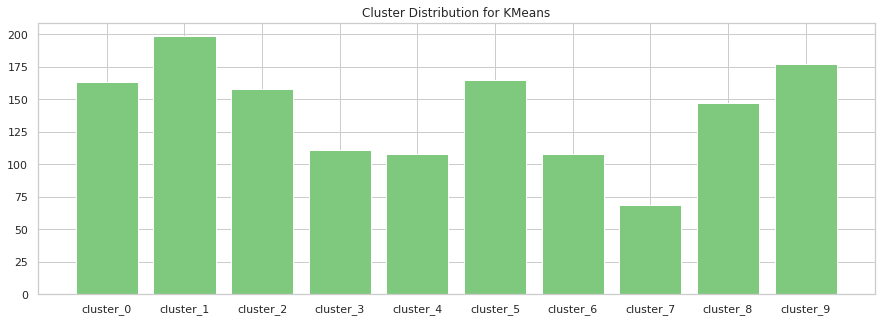

In [29]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

The histogram above shows that these clusters are evenly distributed across all building ids, and therefore is a suitable number.

In [30]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]

ids = data['building_id'].unique()
pd.DataFrame(zip(ids,labels),columns=["building_id","Cluster"]).sort_values(by="Cluster").set_index("building_id")

,Cluster
building_id,
1389,0
671,0
669,0
915,0
886,0
...,...
901,9
1269,9
673,9


### Conclusion and Recommendation

We can conclude by saying that KMeans is a very suitable way of performing time series clustering and load archetype decomposition. However, a careful preperation of the data is required prior to modeling. A common error that can be transfered from the preprocessing stage into the modeling is the scaling error.

The clustering result can be used for further evaluation of potential energy saving incentives or methodologies that can be introduced for each consumption partern. This might require further data analysis processing such as identifying the kinds of building in each cluster. Furthermore, we can find out if there are special conditions (weather, location, topography, etc.) that affects the users.